# DI 501: Classification and Model Tuning
## Part II

## Inspection

In [276]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import warnings
warnings.filterwarnings('ignore')

In [277]:
df1 = pd.read_csv('Maternal Health Risk Data Set.csv')

df1.RiskLevel.value_counts()

RiskLevel
low risk     406
mid risk     336
high risk    272
Name: count, dtype: int64

In [278]:
df1.head()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,98.0,86,high risk
1,35,140,90,13.0,98.0,70,high risk
2,29,90,70,8.0,100.0,80,high risk
3,30,140,85,7.0,98.0,70,high risk
4,35,120,60,6.1,98.0,76,low risk


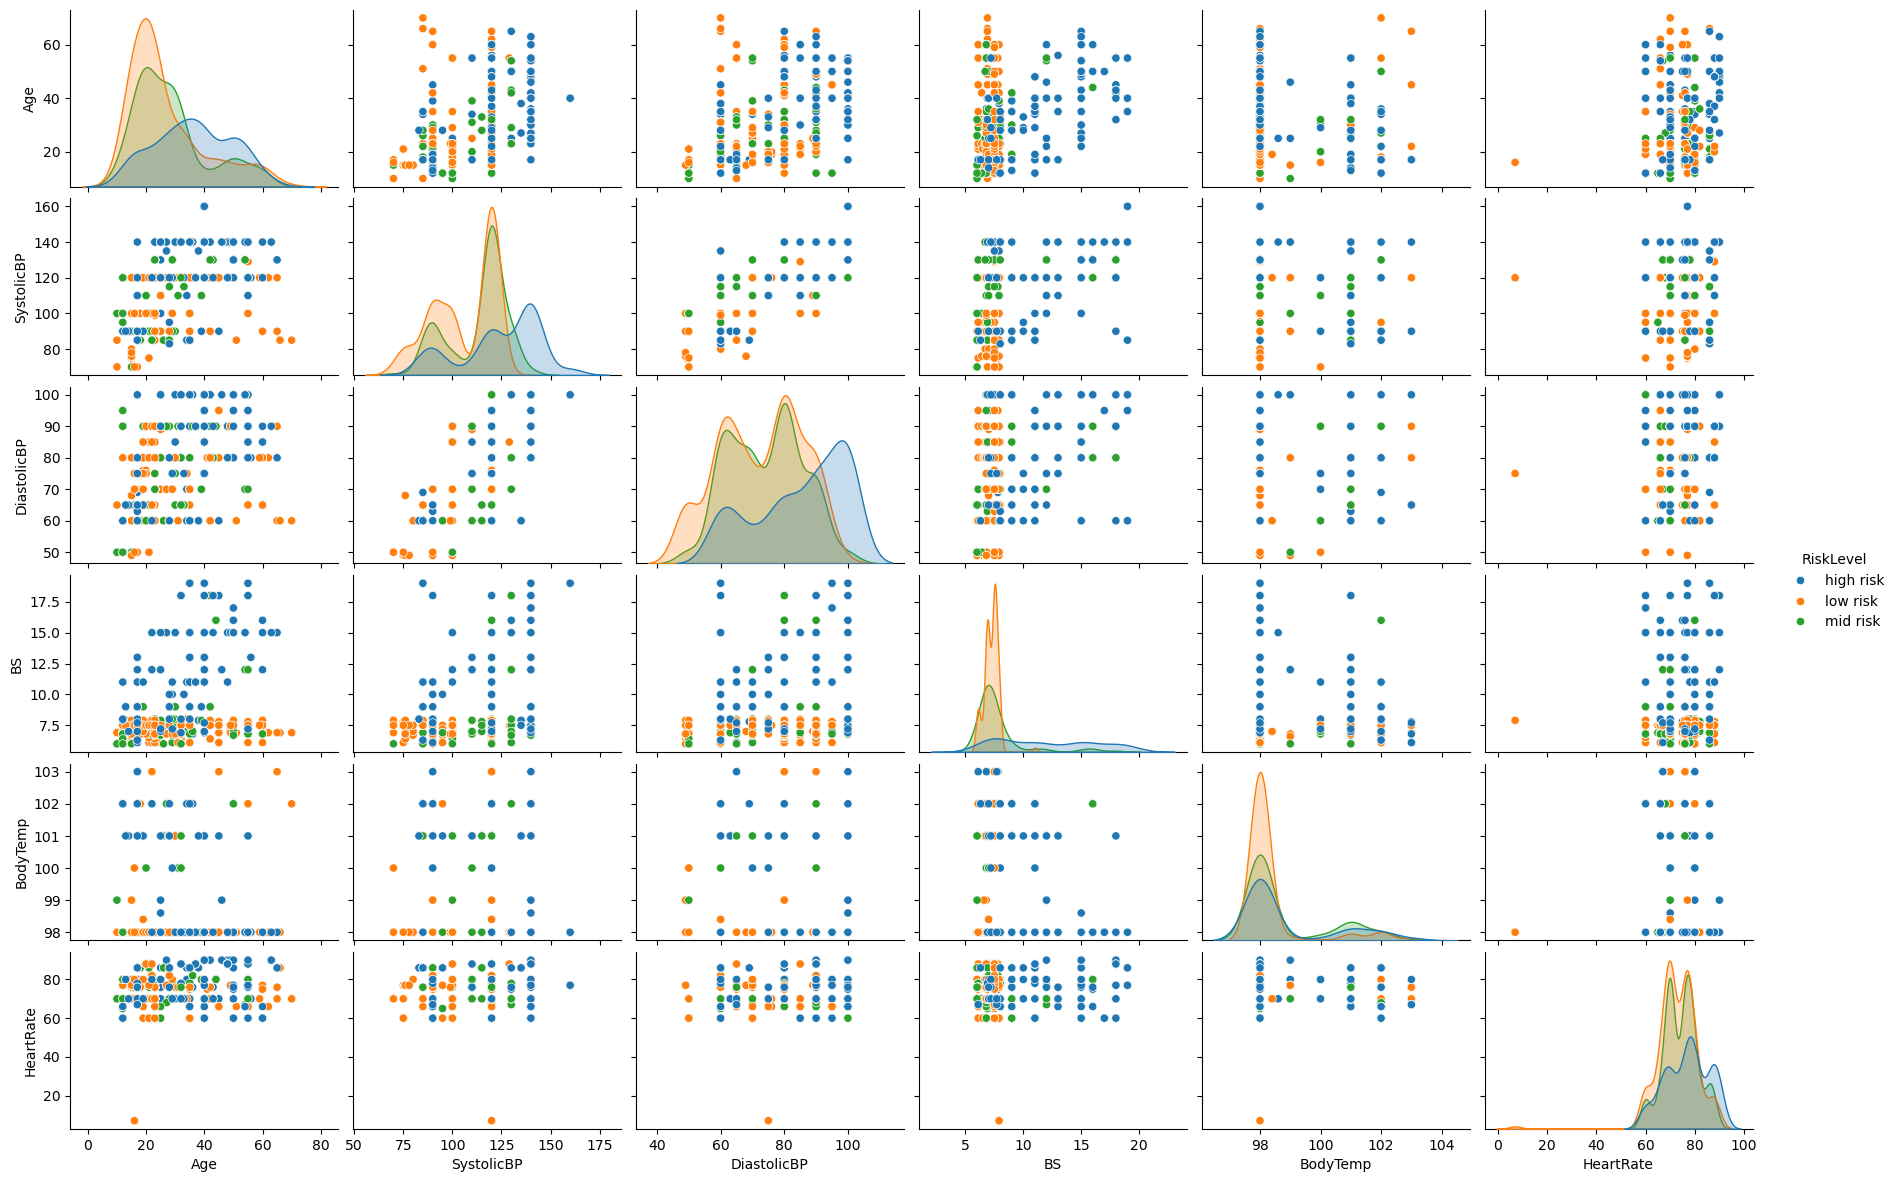

In [279]:
sns.pairplot(df1, hue='RiskLevel', height=2, aspect=1.5);

## Question 1
- Do you observe any unusual or implausible data points in the plot? 

- Perform an initial inspection of the dataset to identify whether there are any unusual  values in the numerical features.

- Based on your findings, apply an appropriate strategy to handle those values — if any exist.



In [280]:
df1.describe()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate
count,1014.000000,1014.000000,1014.000000,1014.000000,1014.000000,1014.000000
mean,29.871795,113.198225,76.460552,8.725986,98.665089,74.301775
std,13.474386,18.403913,13.885796,3.293532,1.371384,8.088702
min,10.000000,70.000000,49.000000,6.000000,98.000000,7.000000
25%,19.000000,100.000000,65.000000,6.900000,98.000000,70.000000
50%,26.000000,120.000000,80.000000,7.500000,98.000000,76.000000
75%,39.000000,120.000000,90.000000,8.000000,98.000000,80.000000
max,70.000000,160.000000,100.000000,19.000000,103.000000,90.000000


The minimum value for HeartRate is 7, which is far below a physiologically acceptable level. This indicates the presence of unrealistic or faulty values that need to be addressed. To correct these values, we used the following line. These values are then replaced with the median heart rate.

In [281]:
df1.HeartRate[df1.HeartRate < 20] = np.median(df1.HeartRate)

In [282]:
print(df1.shape)
df1.nunique()

(1014, 7)


Age            50
SystolicBP     19
DiastolicBP    16
BS             29
BodyTemp        8
HeartRate      15
RiskLevel       3
dtype: int64

We can see some numeric attributes like body temperature weren't measured very precisely, thus we have 8 unique values for 1014 individuals. 

## Question 2:

Is  encoding required here? Explain your reasoning.


## Ordinal Encoder


We use OrdinalEncoder here because the RiskLevel categories have a natural order: "low risk" < "mid risk" < "high risk".
This order may carry semantic meaning and could be useful in interpretation or in algorithms that can leverage ordinal relationships.

This is normally used for attributes, since high values should indicate high "something" to the model. For targets, this isn't very necessary, but just for clarity when explaining results this makes sense to do because applying it to the target helps maintain that ordered structure and keeps our labels consistent and easy to interpret.

Note that we must reshape the target variable into a 2D array for the encoder to work.

In [283]:
X, y = df1.iloc[:,:-1], df1.RiskLevel

oe = OrdinalEncoder(categories = [['low risk','mid risk', 'high risk']])
oe.fit_transform(y.values.reshape(-1,1))

oe.inverse_transform(np.array([0,1,2]).reshape(-1,1))

array([['low risk'],
       ['mid risk'],
       ['high risk']], dtype=object)

In [284]:
y = oe.fit_transform(y.values.reshape(-1,1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1337, stratify=y)

## Hyperparameter Tuning for KNN

In this step, we are performing hyperparameter tuning for the K-Nearest Neighbors (KNN) algorithm using GridSearchCV.

We define a range of values for n_neighbors (the number of neighbors to consider) and evaluate the model using 5-fold cross-validation. The performance metric used is f1_macro, which gives equal weight to all classes — this is especially useful if your dataset is not perfectly balanced.

In [285]:
knn_grid = {'n_neighbors' : range(1,25,2)}

knn = KNeighborsClassifier()

knn_grid_search = GridSearchCV(knn, param_grid=knn_grid, scoring='f1_macro', cv=5, verbose=3, return_train_score=True)

knn_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END .n_neighbors=1;, score=(train=0.925, test=0.796) total time=   0.0s
[CV 2/5] END .n_neighbors=1;, score=(train=0.917, test=0.810) total time=   0.0s
[CV 3/5] END .n_neighbors=1;, score=(train=0.903, test=0.817) total time=   0.0s
[CV 4/5] END .n_neighbors=1;, score=(train=0.942, test=0.816) total time=   0.0s
[CV 5/5] END .n_neighbors=1;, score=(train=0.918, test=0.811) total time=   0.0s
[CV 1/5] END .n_neighbors=3;, score=(train=0.844, test=0.691) total time=   0.0s
[CV 2/5] END .n_neighbors=3;, score=(train=0.854, test=0.737) total time=   0.0s
[CV 3/5] END .n_neighbors=3;, score=(train=0.846, test=0.692) total time=   0.0s
[CV 4/5] END .n_neighbors=3;, score=(train=0.848, test=0.665) total time=   0.0s
[CV 5/5] END .n_neighbors=3;, score=(train=0.864, test=0.757) total time=   0.0s
[CV 1/5] END .n_neighbors=5;, score=(train=0.751, test=0.630) total time=   0.0s
[CV 2/5] END .n_neighbors=5;, score=(train=0.776

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(1, 25, 2)},
             return_train_score=True, scoring='f1_macro', verbose=3)

In this step, we visualize how the KNN model’s performance changes across different values of n_neighbors (K). The plot shows:

The mean F1 score across 5 cross-validation folds (solid line),
And the standard deviation (shaded area), representing the variability in performance.

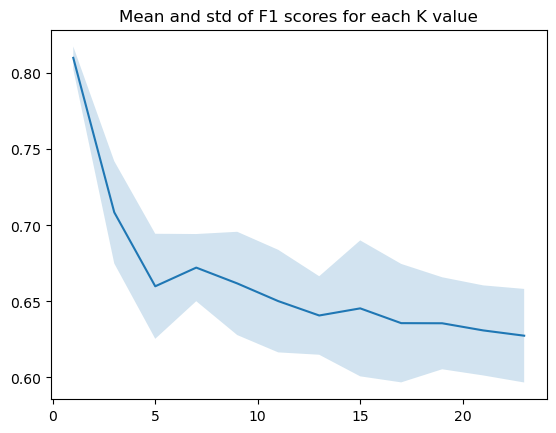

In [286]:
fig, ax = plt.subplots()

mean_f1 = knn_grid_search.cv_results_['mean_test_score']
sd_f1 = knn_grid_search.cv_results_['std_test_score']

ax.plot(knn_grid['n_neighbors'], mean_f1)
ax.fill_between(knn_grid['n_neighbors'], mean_f1+sd_f1, mean_f1-sd_f1, alpha=0.2);

plt.title('Mean and std of F1 scores for each K value');

## Question 3: 
- Which K value would you choose based on this graph? Justify your answer by considering both the mean F1 score and the variance across different K values. 

- Then, execute the code below to retrieve the best KNN model found by the grid search. Were the results what you expected based on the F1 score plot?

In [287]:
best_knn = knn_grid_search.best_estimator_
print(best_knn)


KNeighborsClassifier(n_neighbors=1)


Now that we’ve selected the best value for K using cross-validation, let’s evaluate how well the final KNN model generalizes to unseen data. In this step, we use:

- classification_report() to examine precision, recall, and F1-score for each class (low, mid, and high risk)

- a confusion matrix heatmap to visualize where the model gets things right or wrong — especially which classes are confused with one another


Training Report: 
 ------------------------------------------------------- 
              precision    recall  f1-score   support

    low risk      0.918     0.929     0.924       325
    mid risk      0.882     0.862     0.872       269
   high risk      0.941     0.949     0.945       217

    accuracy                          0.912       811
   macro avg      0.914     0.914     0.914       811
weighted avg      0.912     0.912     0.912       811

Test Report: 
 ------------------------------------------------------- 
              precision    recall  f1-score   support

    low risk      0.870     0.827     0.848        81
    mid risk      0.733     0.821     0.775        67
   high risk      0.941     0.873     0.906        55

    accuracy                          0.837       203
   macro avg      0.848     0.840     0.843       203
weighted avg      0.844     0.837     0.839       203



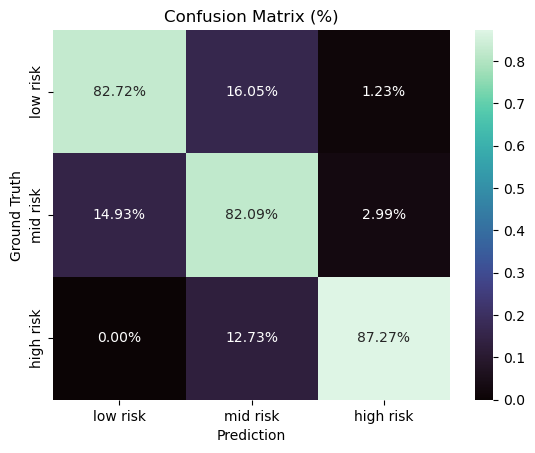

In [288]:

def eval(y_train, train_pred, y_test, test_pred):
    """Generates classification reports 
    for training and test sets and a 
    confusion matrix for the test test set.

    Arguments:
        y_train -- Target for training set
        train_pred -- Predictions for training set
        y_test -- Target for test set
        test_pred -- Predictions for test set
    """    
    print(f'Training Report: \n {"-"*55} \n{classification_report(y_train, train_pred, digits=3, target_names=oe.categories[0])}')
    print(f'Test Report: \n {"-"*55} \n{classification_report(y_test, test_pred, digits=3, target_names=oe.categories[0])}')



    c = confusion_matrix(y_test, test_pred)
    row_sums = c.sum(axis=1, keepdims=True)
    conf_perc = c / row_sums

   
    plt.title('Confusion Matrix')
    sns.heatmap(conf_perc, annot=True, fmt='.2%', cmap='mako',
            xticklabels=oe.categories[0], yticklabels=oe.categories[0])
    plt.ylabel('Ground Truth')
    plt.xlabel('Prediction')
    plt.title('Confusion Matrix (%)')


train_pred = best_knn.predict(X_train)
test_pred = best_knn.predict(X_test)

eval(y_train, train_pred, y_test, test_pred)

The report summarizes the precision, recall, and F1-score for each class (low, mid, high risk) on both the training and test sets.

Notably, the model performs exceptionally well on high risk, both in terms of precision and f1-score.


According to the heatmap:

Mid risk is the most confused class.
However, high risk predictions are  highly accurate, with 82.27% and low misclassification.
This implies that the model can now clearly distinguish high risk individuals — a critical outcome for medical applications.

## Decision Tree

 In this section, we manually explore how different combinations of max_depth and min_samples_leaf affect the performance of a DecisionTreeClassifier. Instead of using GridSearchCV, we do the search explicitly over a validation set.

**Key learning**: To accurately evaluate model performance, each data split should have enough examples per class.
This is why we use a 3-way split:
- 60% training
- 20% validation
- 20% test

Each class must have at least 20 samples per split to ensure stable metrics like F1-score.

For KNN, we used 80% training and 20% test because GridSearchCV already does validation internally. But when we manually tune a model like Decision Tree, we need to explicitly set aside a validation set.

Let's define the following grid for our parameters and evaluate the model performance for each combination on the validation set.

In [289]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=1337, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=1337, stratify=y_temp)



max_depth_values = [2, 4, 8, 16]
min_leaf_values = [1, 2, 3, 4]

results = []

tree_model = DecisionTreeClassifier(random_state=1337)

for max_depth in max_depth_values:
    for min_leaf in min_leaf_values:

        tree_model.max_depth = max_depth
        tree_model.min_samples_leaf = min_leaf

        tree_model.fit(X_train, y_train)
        predictions = tree_model.predict(X_val)

        f1 = f1_score(y_val, predictions, average='macro')
        results.append(f1)

Since we append to a list, we will need to reshape it and rotate it so that it follows our grid for visualisations.

In this step, we visualize the results of a manual grid search for a Decision Tree model using a 3D surface plot.

- Z: 2D matrix of F1 scores on the validation set

- x = max_depth_values: values of max_depth (e.g., 2, 4, 8, 16)

- y = min_leaf_values: values of min_samples_leaf (e.g., 1, 2, 3, 4)

This creates a surface where each point represents the model's validation performance under a specific parameter setting.

Using -1 in reshape lets NumPy automatically calculate the number of columns based on the total number of F1 scores and the number of max_depth values. Since we have 16 data points and 4 depth values, NumPy infers the second dimension as 4.

In [290]:
Z = np.array(results).reshape(len(max_depth_values),-1).T

In [291]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Surface(z=Z, x=max_depth_values, y=min_leaf_values)])

fig.update_layout(title='F1 Score for different max_depth and min_leaf_values', 
                  autosize=False, width=500, height=500,
                  scene=dict(xaxis_title='Max Depth',
                             yaxis_title='Min Sample Leaf',
                             zaxis_title='F1 Score (Val)',
                             xaxis=dict(type='log')))

fig.show()

From the surface plot, we can observe a consistent improvement in validation F1 score as `max_depth` increases, particularly between 2 and 4. 

However, the effect of `min_samples_leaf` is less clear. Since all tested values (1 to 4) yield similar results, this parameter’s influence remains undetermined in the current grid. To clarify its impact, it would be useful to explore additional values such as 5, 6, or 7.

🧠 Takeaway: Don’t settle for your first hyperparameter grid — always let the visual feedback guide further search!


In [292]:
max_depth_values = [2, 4, 8, 16]
min_leaf_values = [4,5,6,7]

results = []

tree_model = DecisionTreeClassifier(random_state=1337)

for max_depth in max_depth_values:
    for min_leaf in min_leaf_values:

        tree_model.max_depth = max_depth
        tree_model.min_samples_leaf = min_leaf

        tree_model.fit(X_train, y_train)
        predictions = tree_model.predict(X_val)

        f1 = f1_score(y_val, predictions, average='macro')
        results.append(f1)

In [293]:
Z = np.array(results).reshape(len(max_depth_values),-1).T

In [294]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Surface(z=Z, x=max_depth_values, y=min_leaf_values)])

fig.update_layout(title='F1 Score for different max_depth and min_leaf_values', 
                  autosize=False, width=500, height=500,
                  scene=dict(xaxis_title='Max Depth',
                             yaxis_title='Min Sample Leaf',
                             zaxis_title='F1 Score (Val)',
                             xaxis=dict(type='log'),
                             yaxis=dict(type='log')))

fig.show()

- Increasing max_depth clearly improves performance — especially moving from shallow trees (depth 2–4) to deeper ones (10–16).
- The trend is smooth and monotonic: the deeper the tree, the better the F1 score, up to a point (around depth 14–16).
- The effect of min_samples_leaf (y-axis) remains negligible — the surface is almost flat along that axis.
We observed that the highest validation F1 score is achieved when using max_depth=16 and min_samples_leaf=5. 

**Of note:** we use a logarithmic scale on the x-axis (max_depth) to improve visual clarity. Without it, values like 2, 4, 8, and 16 would appear too close together, making the surface hard to interpret.

We will use this setting to initialize and train our final Decision Tree model.

Training Report: 
 ------------------------------------------------------- 
              precision    recall  f1-score   support

    low risk      0.857     0.840     0.848       243
    mid risk      0.724     0.792     0.757       202
   high risk      0.933     0.853     0.891       163

    accuracy                          0.827       608
   macro avg      0.838     0.828     0.832       608
weighted avg      0.833     0.827     0.829       608

Test Report: 
 ------------------------------------------------------- 
              precision    recall  f1-score   support

    low risk      0.747     0.802     0.774        81
    mid risk      0.529     0.537     0.533        67
   high risk      0.792     0.691     0.738        55

    accuracy                          0.685       203
   macro avg      0.689     0.677     0.682       203
weighted avg      0.687     0.685     0.685       203



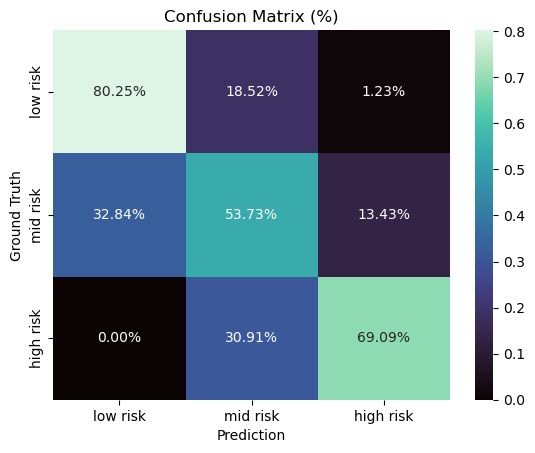

In [295]:
final = DecisionTreeClassifier(random_state=1337, max_depth=16, min_samples_leaf=5)
final.fit(X_train,y_train)

train_pred = final.predict(X_train)
test_pred = final.predict(X_test)

eval(y_train, train_pred, y_test, test_pred)


| Metric (Test Set) | KNN   | Decision Tree (Final) |
|-------------------|-------|------------------------|
| **Precision**     | 84.8% | 69.8%                  |
| **Recall**        | 84.0% | 69.0%                  |
| **F1-Score**      | 84.3% | 68.9%                  |

> *All values are macro averages across the three classes.*


While the Decision Tree achieves moderate overall performance, its poor generalization on the high risk class limits its reliability in practice. The confusion matrix reveals significant misclassifications, particularly between mid and high risk.



KNN is better than our final model.

Now, let's generate a graphical representation of the trained Decision Tree model using sklearn.

tree.plot_tree() draws the structure of the trained decision tree, showing:
- the feature used at each split (feature_names)
- decision thresholds
- number of samples and class distribution at each node
- predicted class at each leaf

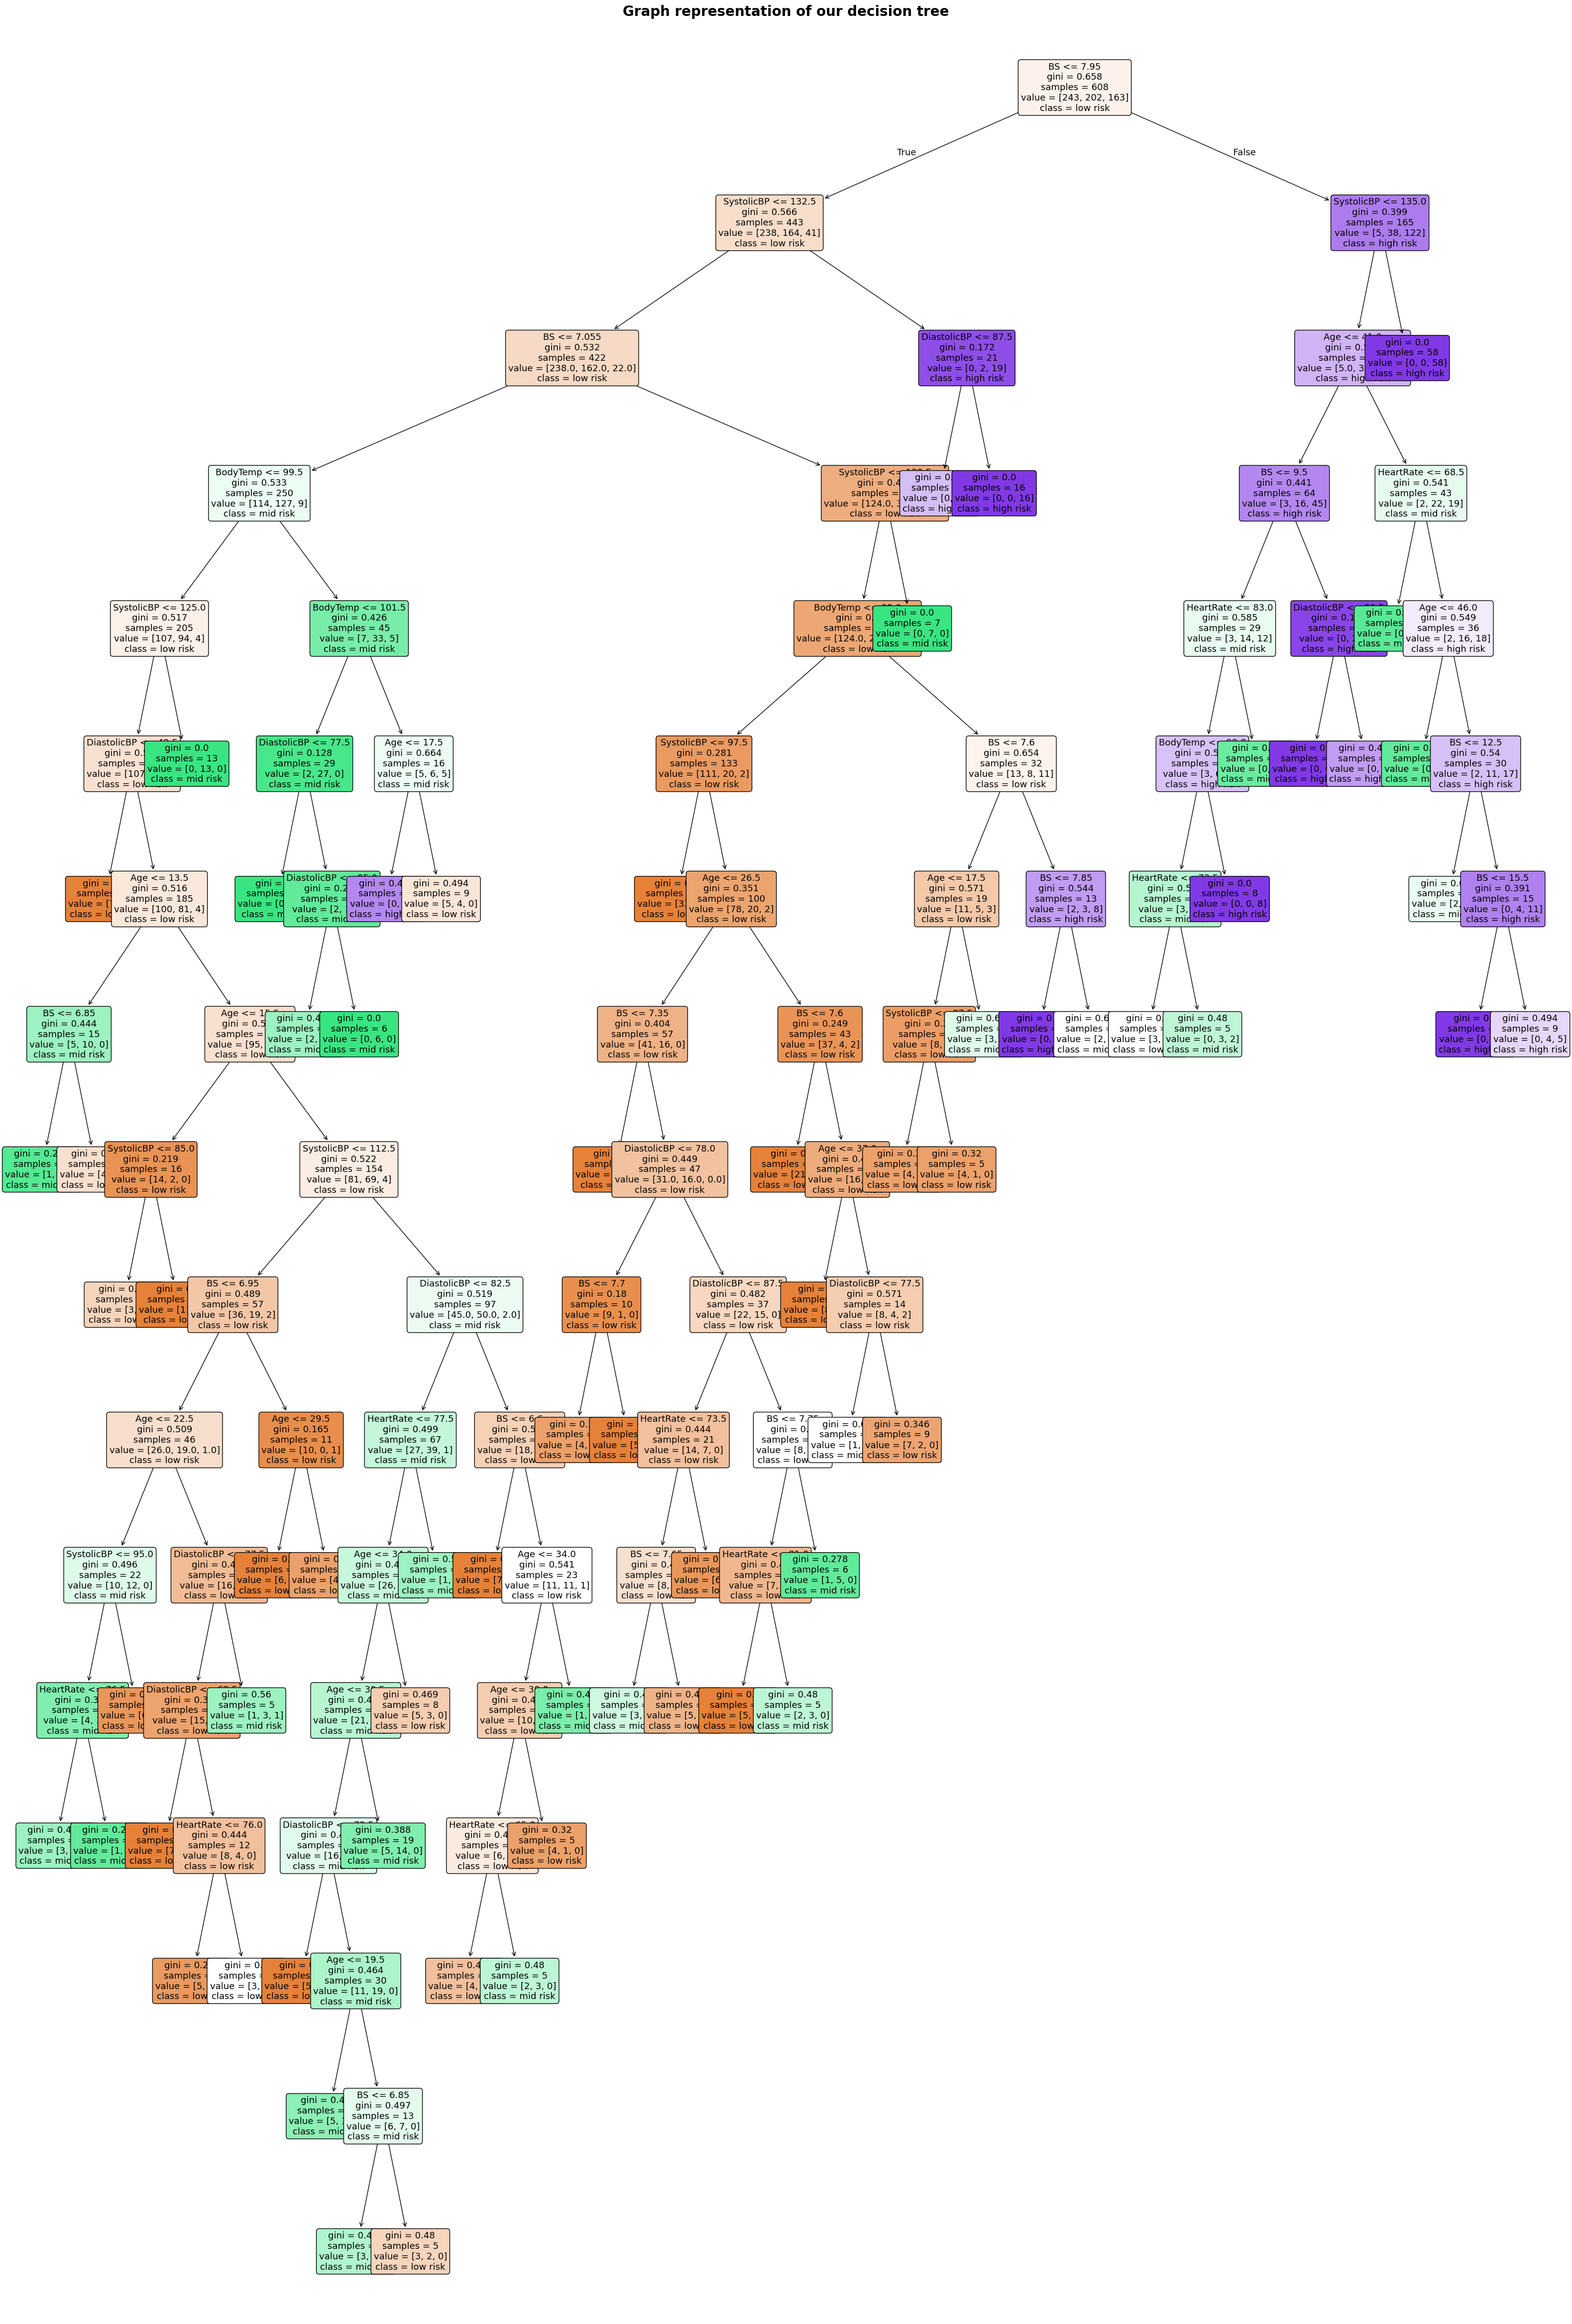

In [296]:
import matplotlib.pyplot as plt
from sklearn import tree

plt.figure(figsize=(40, 60))
tree.plot_tree(final,
               rounded=True,
               filled=True,
               fontsize=13,
               class_names=list(oe.categories_[0]),         
               feature_names=list(X.columns))               

plt.title('Graph representation of our decision tree', size=20, weight='bold')
plt.show()





- The root node splits on Blood Sugar (BS ≤ 7.95), indicating it’s the most important feature in the model.

- Gini is used to measure how pure or mixed each node is in terms of class labels. If a node contains samples from multiple classes, the Gini impurity is high. If a node contains samples from only one class, the Gini impurity is 0 — “fully confident”.


- Features like SystolicBP, DiastolicBP, and BodyTemp are heavily used in the splits, showing they are strong predictors. Let's see which values were given the most and least importance by the model.

In [297]:
feat = pd.DataFrame(final.feature_importances_, X.columns, columns=['importance'])

feat.sort_values('importance', ascending=False, inplace=True)

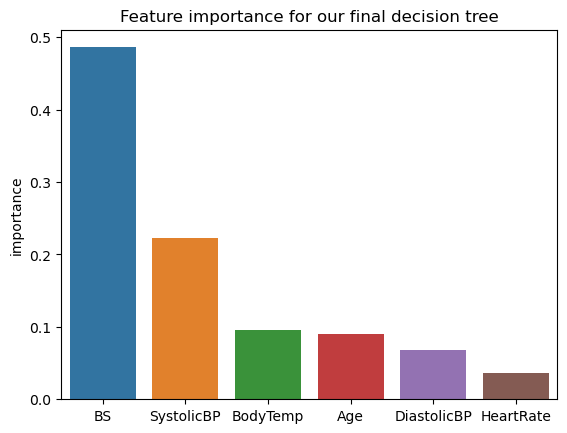

In [298]:
sns.barplot(feat, x=feat.index, y=feat.importance, hue=feat.index)
plt.xlabel('')
plt.title('Feature importance for our final decision tree');

- While DiastolicBP and HeartRate were used less frequently in split points compared to BS and SystolicBP, they were not completely ignored.
- The lower importance scores suggest that these features contributed less to reducing Gini impurity across the tree.
- DiastolicBP's high correlation with SystolicBP may have led the model to favor SystolicBP for splits, as it already captured much of the signal.

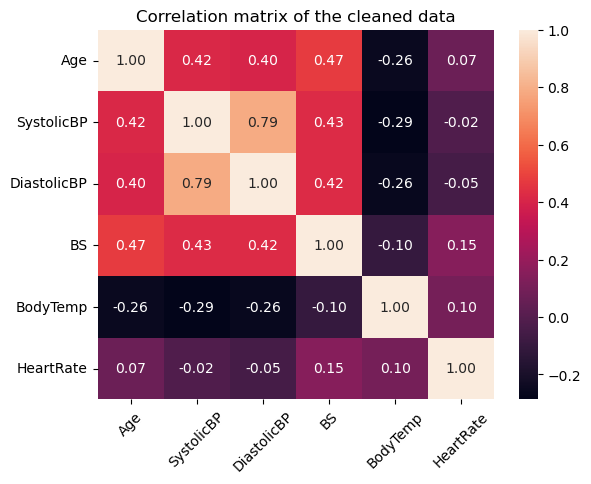

In [299]:
sns.heatmap(X.corr(),xticklabels=X.columns,yticklabels=X.columns, annot=True, fmt='.2f');
plt.title('Correlation matrix of the cleaned data')
plt.xticks(rotation=45);

## Duplicates?

## Question 4
- Identify how many duplicate samples exist in each class.

- What could be the potential impact of removing duplicate rows from a dataset on model performance?

In [300]:
print(df1[df1.duplicated()]['RiskLevel'].value_counts())


RiskLevel
mid risk     230
low risk     172
high risk    160
Name: count, dtype: int64


In [301]:
from sklearn.preprocessing import LabelEncoder

# Drop duplicates
print(f"Dataset size before dropping duplicates: {len(df1)}")
df1_cleaned = df1.drop_duplicates()
print(f"Dataset size after dropping duplicates: {len(df1_cleaned)}\n")

# Check class-wise repetition ratio
print('Repetition amount per class on average:')
print(df1.RiskLevel.value_counts() / df1_cleaned.RiskLevel.value_counts())
print('\n')

# Separate features and target
X = df1_cleaned.iloc[:, :-1]
y = df1_cleaned.RiskLevel

# Label encode target
le = LabelEncoder()
y = le.fit_transform(y)

# 1. Split off test set (20%)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=1337)

# 2. Split remaining 80% into train (60%) and validation (20%)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, stratify=y_train_val, random_state=1337)

Dataset size before dropping duplicates: 1014
Dataset size after dropping duplicates: 452

Repetition amount per class on average:
RiskLevel
high risk    2.428571
low risk     1.735043
mid risk     3.169811
Name: count, dtype: float64




In [302]:
knn_grid = {'n_neighbors' : range(1,25,2)}

knn = KNeighborsClassifier()

knn_grid_search = GridSearchCV(knn, param_grid=knn_grid, scoring='f1_macro', cv=5, verbose=3, return_train_score=True)

knn_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END .n_neighbors=1;, score=(train=0.963, test=0.449) total time=   0.0s
[CV 2/5] END .n_neighbors=1;, score=(train=0.966, test=0.522) total time=   0.0s
[CV 3/5] END .n_neighbors=1;, score=(train=0.957, test=0.497) total time=   0.0s
[CV 4/5] END .n_neighbors=1;, score=(train=0.936, test=0.488) total time=   0.0s
[CV 5/5] END .n_neighbors=1;, score=(train=0.966, test=0.506) total time=   0.0s
[CV 1/5] END .n_neighbors=3;, score=(train=0.727, test=0.516) total time=   0.0s
[CV 2/5] END .n_neighbors=3;, score=(train=0.708, test=0.522) total time=   0.0s
[CV 3/5] END .n_neighbors=3;, score=(train=0.686, test=0.463) total time=   0.0s
[CV 4/5] END .n_neighbors=3;, score=(train=0.730, test=0.494) total time=   0.0s
[CV 5/5] END .n_neighbors=3;, score=(train=0.715, test=0.546) total time=   0.0s
[CV 1/5] END .n_neighbors=5;, score=(train=0.652, test=0.519) total time=   0.0s
[CV 2/5] END .n_neighbors=5;, score=(train=0.649

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(1, 25, 2)},
             return_train_score=True, scoring='f1_macro', verbose=3)

Training Report: 
 ------------------------------------------------------- 
              precision    recall  f1-score   support

    low risk      0.781     0.758     0.769        66
    mid risk      0.707     0.914     0.798       140
   high risk      0.680     0.266     0.382        64

    accuracy                          0.722       270
   macro avg      0.723     0.646     0.650       270
weighted avg      0.719     0.722     0.692       270

Test Report: 
 ------------------------------------------------------- 
              precision    recall  f1-score   support

    low risk      0.786     0.478     0.595        23
    mid risk      0.632     0.915     0.748        47
   high risk      0.111     0.048     0.067        21

    accuracy                          0.604        91
   macro avg      0.510     0.480     0.470        91
weighted avg      0.551     0.604     0.552        91



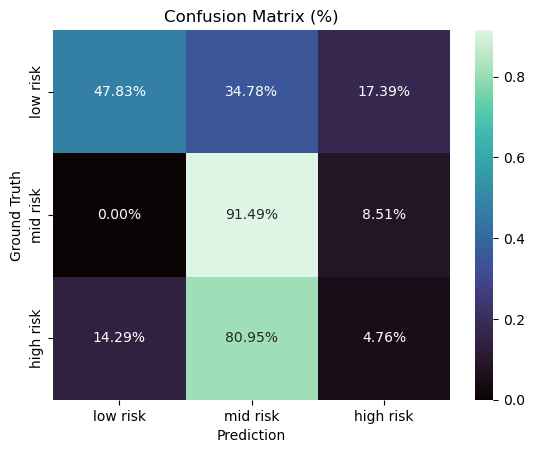

In [303]:

best_knn = knn_grid_search.best_estimator_

train_pred = best_knn.predict(X_train)
test_pred = best_knn.predict(X_test)

# Evaluate
eval(y_train, train_pred, y_test, test_pred)


This indicates that KNN was significantly benefiting from the presence of duplicate data.
Since KNN is a distance-based algorithm, having repeated identical samples reinforces decision boundaries and leads to artificially high performance.
Once those duplicates are removed, the model's true generalization ability becomes more evident — revealing a more realistic but lower performance.

| Metric (Test Set)       | KNN (Before Duplicates) | Decision Tree (Final) | KNN (After Removing Duplicates) |
|-------------------------|-------------------------|------------------------|-------------------------|
| **Precision**           | 84.8%                   | 69.8%                  | 51.0%                   |
| **Recall**              | 84.0%                   | 69.0%                  | 48.0%                   |
| **F1-Score**            | 84.3%                   | 68.9%                  | 47.0%                   |


> *All values are macro averages across the three classes.*
